In [1]:
from model import *
from data import *
import datetime


## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [ ]:
""" from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from tensorflow.keras.callbacks import ModelCheckpoint
from your_model_module import unet  # 导入你的模型
from your_data_generator_module import trainGenerator  # 导入你的数据生成器
from utils import show_history  # 导入显示训练历史的工具函数
import numpy as np

# 定义数据增强参数和路径
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')


# 创建模型实例
model = unet()

# 创建三重交叉验证的交叉验证对象
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# 选择性能度量，例如准确率
scorer = make_scorer(accuracy_score)

# 获取数据路径等信息，替换成你的实际情况
data_path = 'data/membrane/train'
img_folder = 'CFD_img'
mask_folder = 'CFD_mask'

# 进行三重交叉验证
for train_idx, val_idx in kfold.split(range(len(your_data))):  # 替换成你的实际数据
    # 根据索引划分训练集和验证集
    train_data = your_data[train_idx]
    val_data = your_data[val_idx]

    # 创建数据生成器
    myGene = trainGenerator(2, data_path, img_folder, mask_folder, data_gen_args, save_to_dir=None)

    # 创建模型
    model = create_model()

    # 定义模型检查点
    model_checkpoint = ModelCheckpoint('unet_prelu100.h5', monitor='loss', verbose=1, save_best_only=True)

    # 训练模型
    history = model.fit_generator(myGene, steps_per_epoch=1000, epochs=100, callbacks=[model_checkpoint])

    # 显示训练历史
    show_history(history, True)

    # 在验证集上评估模型
    # 这里需要根据你的实际情况进行评估，以下代码仅供参考
    val_score = model.evaluate(val_data)

    print("Validation Score:", val_score)

# 你可能需要在整个数据上重新训练最终模型，以获得更好的性能
final_model = create_model()
final_model.fit_generator(myGene, steps_per_epoch=1000, epochs=100, callbacks=[model_checkpoint])

# 最终模型的训练历史
final_history = final_model.history.history

# 显示最终模型的训练历史
show_history(final_history, True) """


In [2]:
import matplotlib.pyplot as plt
def show_history(history, validation : bool = False):
    if validation:
        # Loss
        fig, axes = plt.subplots(figsize= (10,5))
        # Train
        axes.plot(history.epoch, history.history['loss'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_loss'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Loss')
        axes.legend()
        # Acc
        fig, axes = plt.subplots(figsize= (10,5))
        # Train
        axes.plot(history.epoch, history.history['accuracy'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_accuracy'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('accuracy')
        axes.legend()

    else:
        fig, axes = plt.subplots(1,4, figsize= (10,5))
        # loss
        axes[0].plot(history.epoch, history.history['loss'])
        axes[0].set_title('Train')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        # Acc
        axes[1].plot(history.epoch, history.history['accuracy'])
        axes[1].set_title('Train')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('accuracy')

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, data_generator, name):
        super(MetricsCallback, self).__init__()
        self.data_generator = data_generator
        self.name = name
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Number of samples - {len(self.data_generator)}")
    
    def on_epoch_end(self, epoch, logs=None):
        # Generate a batch of data
        data_batch, labels_batch = next(self.data_generator)

        # Make predictions on the batch
        predictions = self.model.predict(data_batch)

        # Convert predictions to binary values
        predictions[predictions > 0.5] = 1
        predictions[predictions <= 0.5] = 0

        # Convert true labels to binary values
        labels_batch[labels_batch > 0.5] = 1
        labels_batch[labels_batch <= 0.5] = 0

        # Flatten labels and predictions for metric calculation
        labels_flat = labels_batch.flatten()
        predictions_flat = predictions.flatten()
        
        if labels_flat.shape != predictions_flat.shape:
            raise ValueError(f"Shapes of labels and predictions do not match: {labels_flat.shape} vs {predictions_flat.shape}")
        
        # Calculate metrics
        precision = precision_score(labels_flat, predictions_flat)
        recall = recall_score(labels_flat, predictions_flat)
        f1 = f1_score(labels_flat, predictions_flat)

        print(f'{self.name}_precision: {precision:.4f}, {self.name}_recall: {recall:.4f}, {self.name}_f1: {f1:.4f}')

In [3]:
""" import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

class ValMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data_generator, steps_per_epoch):
        super(ValMetricsCallback, self).__init__()
        self.validation_data_generator = validation_data_generator
        self.steps_per_epoch = steps_per_epoch

    def on_epoch_end(self, epoch, logs=None):
        # 初始化预测和标签列表
        all_predictions = []
        all_labels = []

        # 遍历验证数据生成器
        for i in range(self.steps_per_epoch):
            data_batch, labels_batch = next(self.validation_data_generator)
            predictions = self.model.predict(data_batch)

            # 将预测结果和标签添加到列表
            all_predictions.append(predictions)
            all_labels.append(labels_batch)

        # 将列表转换为 NumPy 数组并将维度展平
        all_predictions = np.vstack(all_predictions).flatten()
        all_labels = np.vstack(all_labels).flatten()

        # 将预测和标签二值化
        all_predictions_binary = (all_predictions > 0.5).astype('int')
        all_labels_binary = (all_labels > 0.5).astype('int')

        # 计算精确率、召回率和 F1 分数
        precision = precision_score(all_labels_binary, all_predictions_binary)
        recall = recall_score(all_labels_binary, all_predictions_binary)
        f1 = f1_score(all_labels_binary, all_predictions_binary)

        # 打印指标
        print(f'\nEpoch {epoch+1}: val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_f1: {f1:.4f}\n') """


loss=dice

In [15]:
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'','CFD_train','CFD_trainmask',data_gen_args,save_to_dir = None)
valgene = valGenerator(2, "", "CFD_val", "CFD_valmask")
model = unet()

#metrics_callback = ValMetricsCallback(valgene,steps_per_epoch=200)

# Then, create an instance of the AdditionalMetrics callback

model_checkpoint = ModelCheckpoint('unet_relu.h5', monitor='val_f1_score',mode='max',verbose=1, save_best_only=True)
# Include it in the callbacks list

history = model.fit_generator(
    myGene,
    steps_per_epoch=410,
    validation_data=valgene,
    validation_steps=120,
    epochs=20,
    callbacks=[model_checkpoint]#, metrics_callback]
)
#show_history(history, True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 256, 256, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_72[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_73[0][0]                  
____________________________________________________________________________________________

C:\Users\ru83m\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


410/410 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9829 - precision_3: 0.0092 - recall_3: 9.6619e-04 - f1_score: 5.5964e-05Found 25 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
410/410 [==============================] - 26s 59ms/step - loss: 0.0944 - accuracy: 0.9829 - precision_3: 0.0092 - recall_3: 9.6619e-04 - f1_score: 5.5964e-05 - val_loss: 0.0508 - val_accuracy: 0.9671 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.0000e+00

Epoch 00001: val_f1_score improved from -inf to 0.00000, saving model to unet_relu.h5
Epoch 2/20
410/410 [==============================] - 24s 58ms/step - loss: 0.0401 - accuracy: 0.9845 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.0457 - val_accuracy: 0.9664 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.0000e+00

Epoch 00002: val_f1_score did not improve from 0.00000
Epoch 3/20
410/410 [====================

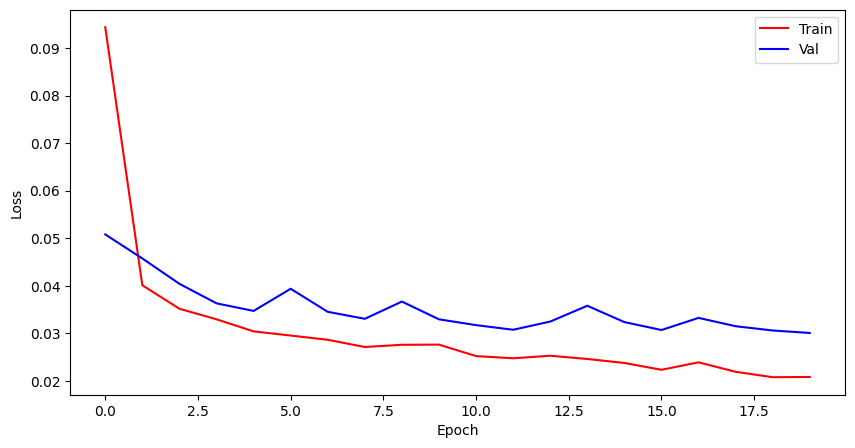

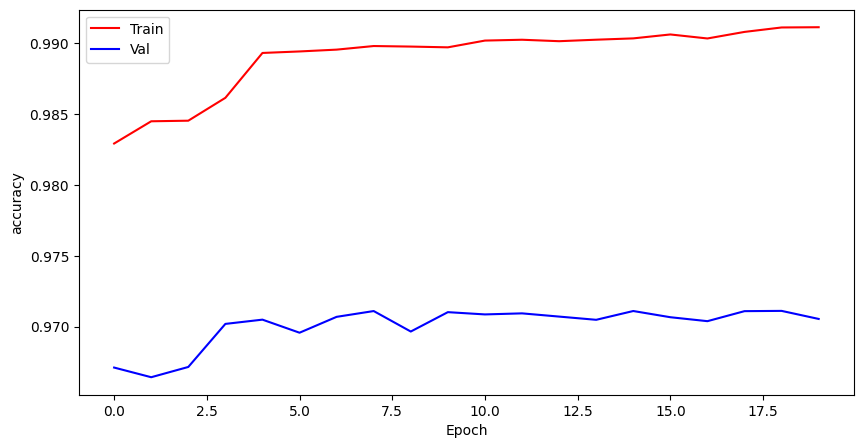

In [20]:
show_history(history, True)

loss=bin

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(8,'','train','train_mask',data_gen_args,save_to_dir = None)
valgene = valGenerator(8, "", "val", "val_mask")
model = unet()

#metrics_callback = ValMetricsCallback(valgene,steps_per_epoch=200)

# Then, create an instance of the AdditionalMetrics callback

model_checkpoint = ModelCheckpoint('unet_relu.h5', monitor='f1_score',mode='max',verbose=1, save_best_only=True)
# Include it in the callbacks list

history = model.fit_generator(
    myGene,
    steps_per_epoch=500,
    validation_data=valgene,
    validation_steps=50,
    epochs=10,
    callbacks=[model_checkpoint]#, metrics_callback]
)
#show_history(history, True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

C:\Users\ru83m\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.9809 - precision: 0.0209 - recall: 0.0029 - f1_score: 1.3643e-04Found 25 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
500/500 [==============================] - 136s 249ms/step - loss: 0.5901 - accuracy: 0.9809 - precision: 0.0209 - recall: 0.0029 - f1_score: 1.3643e-04 - val_loss: 0.4924 - val_accuracy: 0.9765 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00

Epoch 00001: f1_score improved from -inf to 0.00014, saving model to unet_relu.h5
Epoch 2/10
500/500 [==============================] - 113s 227ms/step - loss: 0.4238 - accuracy: 0.9832 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.3582 - val_accuracy: 0.9767 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00

Epoch 00002: f1_score did not improve from 0.00014
Epoch 3/10
500/500 [==============================] - 116s 231ms/step - 

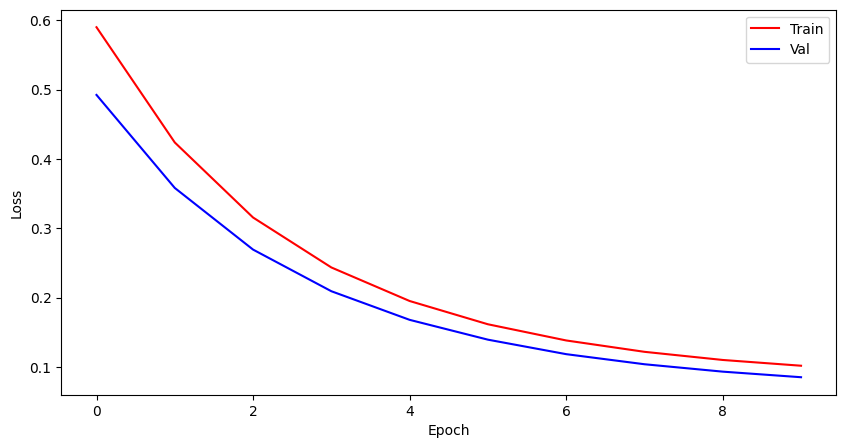

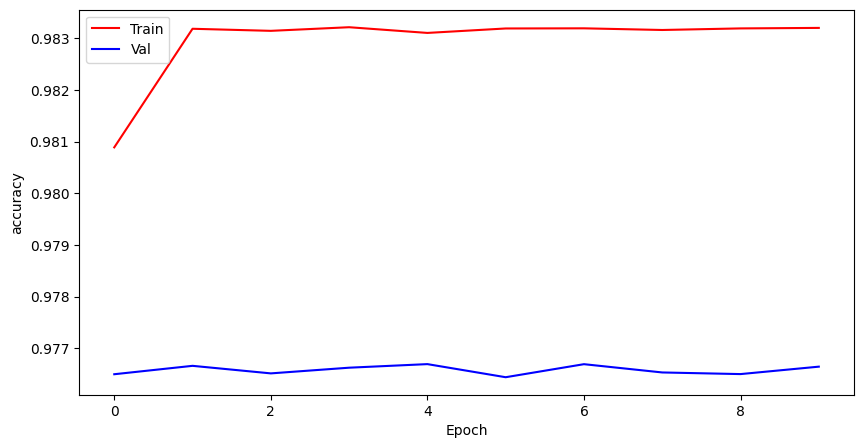

In [5]:
show_history(history, True)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 256, 256, 32) 320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_120[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_121[0][0]                 
____________________________________________________________________________________________

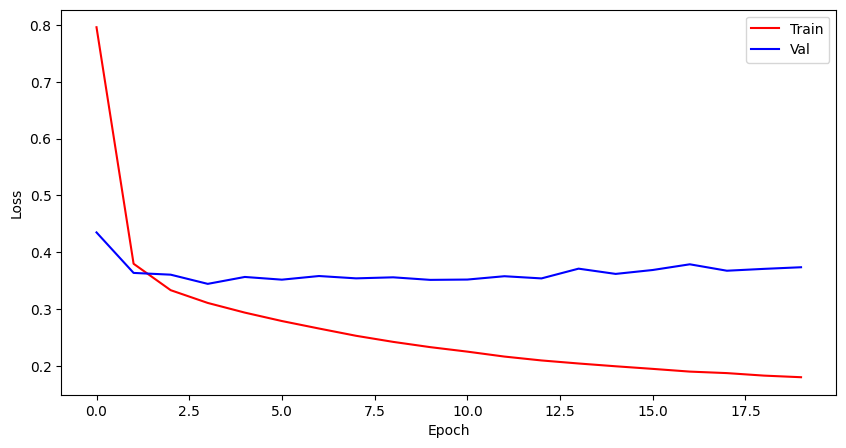

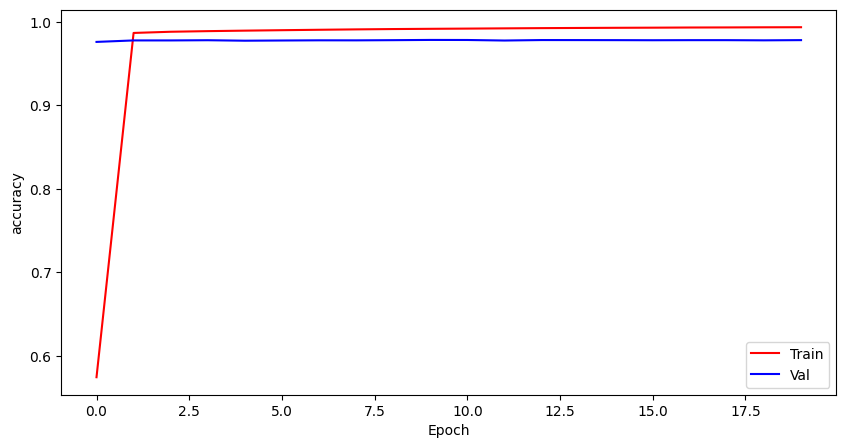

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(8,'','train','train_mask',data_gen_args,save_to_dir = None)
valgene = valGenerator(8, "", "val", "val_mask")
model = unet()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#train_metrics_callback = MetricsCallback(data_generator=myGene, name='train')
#val_metrics_callback = MetricsCallback(data_generator=valgene, name='val')


model_checkpoint = ModelCheckpoint('unet_relu.h5', monitor='loss',verbose=1, save_best_only=True)
history=model.fit_generator(myGene,validation_data=valgene,steps_per_epoch=640,validation_steps=100,epochs=20,callbacks=[tensorboard_callback,model_checkpoint])
show_history(history, True)


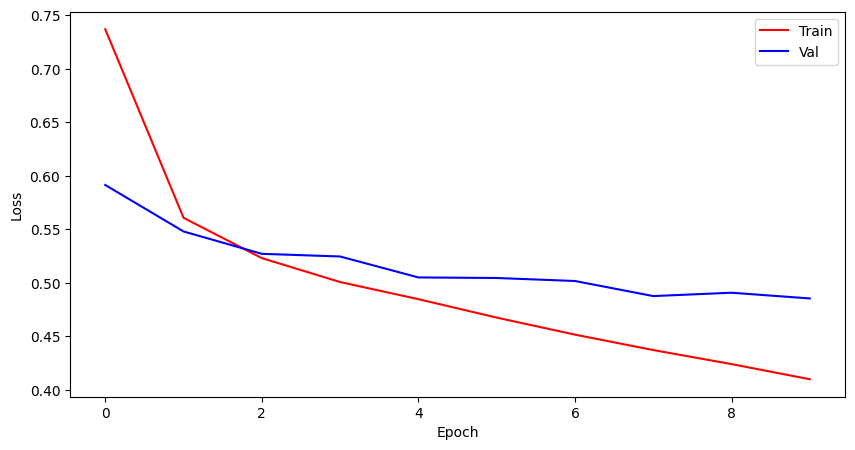

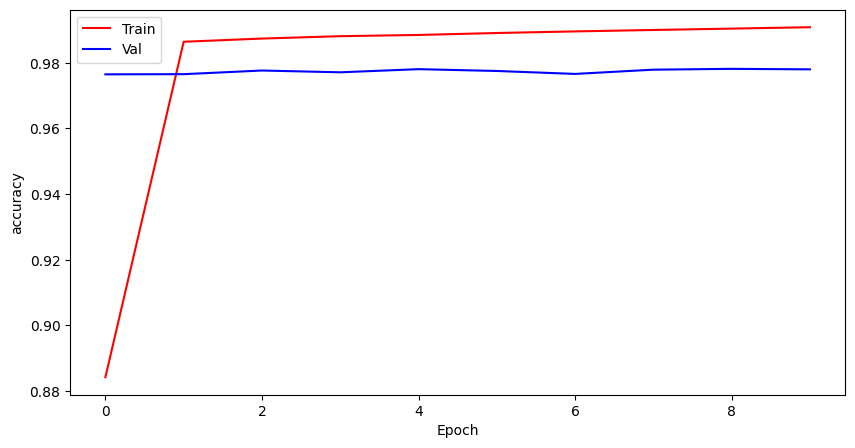

In [6]:
import matplotlib.pyplot as plt
show_history(history, True)

In [8]:
from keras.models import load_model

model.save("unet_relu.h5")

AttributeError: 'str' object has no attribute 'save'

In [28]:
import os

log_dir = 'logs/fit'

if os.path.exists(log_dir):
    print(f"The log directory '{log_dir}' exists.")
else:
    print(f"The log directory '{log_dir}' does not exist.")


The log directory 'logs/fit' exists.


In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

In [17]:
def predict_and_visualize_images(model_filename, image_folder, label_folder, num_images=5, traget_size=(256, 256)):
    # 加载模型
    #model = tf.keras.models.load_model(model_filename)
    model = load_model(model_filename, custom_objects={'f1_score': f1_score})
    # 列出文件夹中的所有图像文件
    image_files = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.png')]

    # 随机选择指定数量的图像
    selected_images = random.sample(image_files, num_images)

    for image_path in selected_images:
        # 读取原始图像和ground truth
        original_image = Image.open(image_path)
        ground_truth_path = os.path.join(label_folder, os.path.basename(image_path))  # 使用 ground_truth_folder 参数
        ground_truth_image = Image.open(ground_truth_path)

        # 调整图像大小
        original_image = original_image.resize(traget_size)
        ground_truth_image = ground_truth_image.resize(traget_size)

        input_image_array = np.array(original_image)
        ground_truth_array = np.array(ground_truth_image)

        input_image_array = np.expand_dims(input_image_array, axis=-1)
        ground_truth_array = np.expand_dims(ground_truth_array, axis=-1)

        predictions = model.predict(np.expand_dims(input_image_array, axis=0))
        output_image = (predictions[0] * 255).astype(np.uint8)
        

        # 提取图像文件名（不带路径）
        image_filename = os.path.basename(image_path)

        # 显示原始图像、ground truth和预测结果图像
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(original_image, cmap='gray')  # 显示原始图像
        plt.title('Original Image', fontsize=14)

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth_image, cmap='gray')  # 显示ground truth
        plt.title('Ground Truth', fontsize=14)

        plt.subplot(1, 3, 3)
        plt.imshow(output_image, cmap='gray')  # 显示预测图像
        plt.title('Predicted Image', fontsize=14)
        plt.suptitle(image_filename, fontsize=16)
        plt.show()

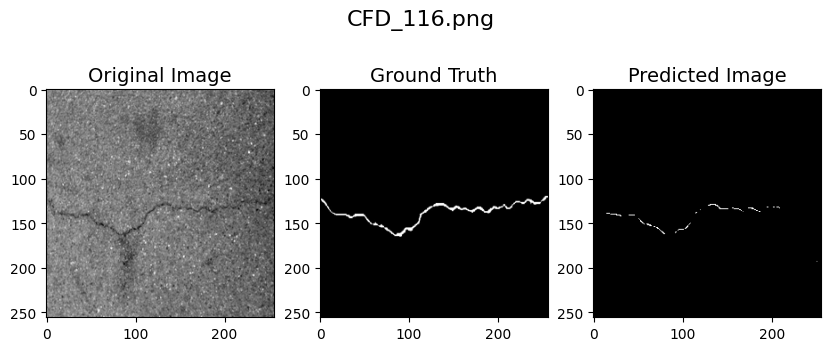

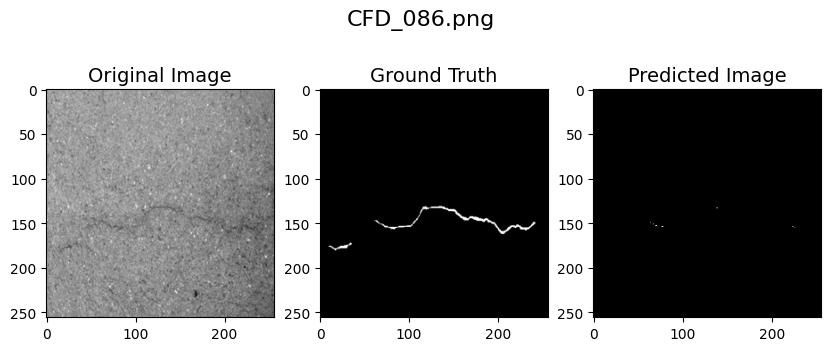

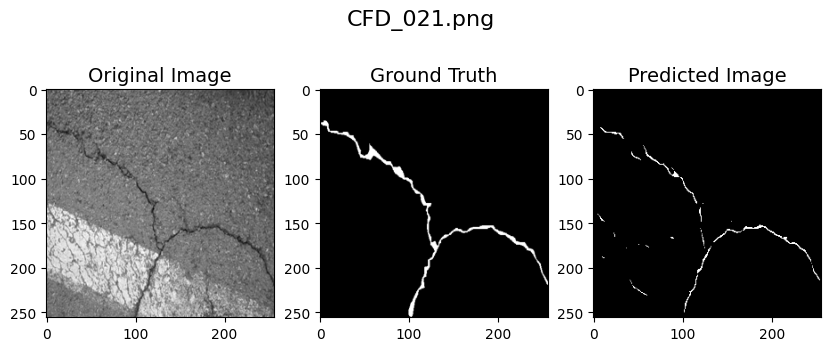

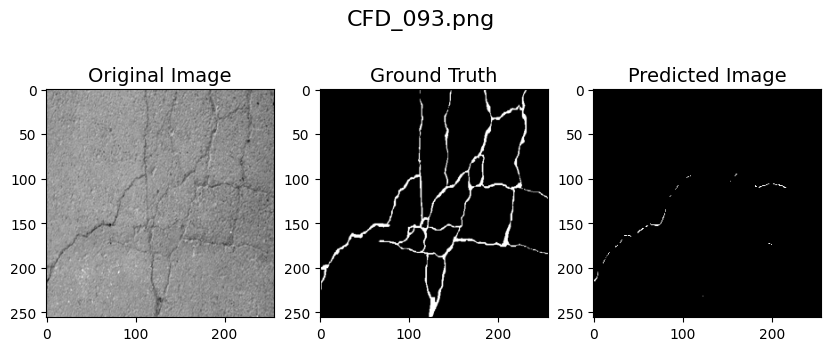

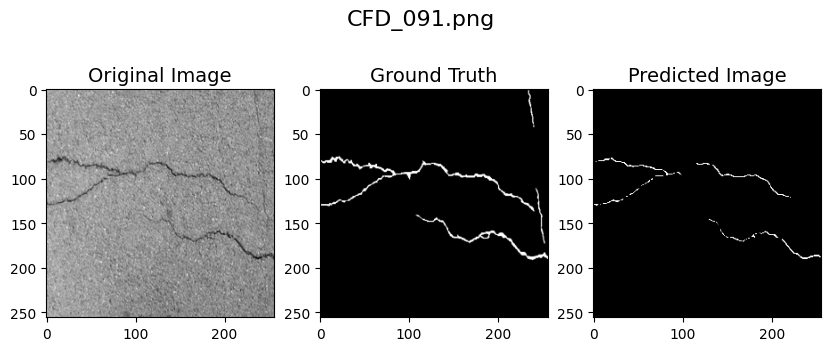

In [21]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import *
img_folder="CFD_test"
label_folder="CFD_testmask"
model="unet_relu.h5"
predict_and_visualize_images(model,img_folder, label_folder, num_images=5,traget_size=(256, 256))

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, jaccard_score

def predict_image(model, image_path, label_folder, target_size=(256, 256)):
        original_image = Image.open(image_path)
        ground_truth_path = os.path.join(label_folder, os.path.basename(image_path))
        ground_truth_image = Image.open(ground_truth_path)

        input_image = original_image.resize(target_size)
        ground_truth_image = ground_truth_image.resize(target_size)

        input_image_array = np.array(input_image)
        ground_truth_array = np.array(ground_truth_image)

        input_image_array = np.expand_dims(input_image_array, axis=-1)
        ground_truth_array = np.expand_dims(ground_truth_array, axis=-1)

        predictions = model.predict(np.expand_dims(input_image_array, axis=0))
        

        return predictions, ground_truth_array

def compute_confusion_metrics(predictions, ground_truths, threshold=0.5):
    binary_predictions = (predictions > threshold).astype(np.uint8)
    binary_ground_truths = (ground_truths > 0.5).astype(np.uint8)

    confusion_mat = confusion_matrix(binary_ground_truths.flatten(), binary_predictions.flatten())

    print("Confusion Matrix:")
    print(confusion_mat)

    accuracy = accuracy_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    precision_metric = precision_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    recall = recall_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    jaccard_similarity = jaccard_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    f1_score = 2 * (precision_metric * recall) / (precision_metric + recall)
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision_metric))
    print("Recall: {:.4f}".format(recall))
    print("f1_score: {:.4f}".format(f1_score))
    print("Jaccard Similarity: {:.4f}".format(jaccard_similarity))

def main():
    # 加载模型
    #model = tf.keras.models.load_model(model_filename)
    model = load_model(model_filename, custom_objects={'f1_score': f1_score})
    # 获取测试图像文件列表
    test_image_files = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) if filename.endswith('.png')]

    # 初始化列表来存储所有预测和真实标签
    all_predictions = []
    all_ground_truths = []
    
    # 遍历所有测试图像并获取预测和真实标签
    for image_path in test_image_files:
        predictions, ground_truth = predict_image(model, image_path, label_folder)
        all_predictions.append(predictions)
        all_ground_truths.append(ground_truth)

    # 将列表转换为NumPy数组
    all_predictions = np.array(all_predictions)
    all_ground_truths = np.array(all_ground_truths)

    # 计算混淆矩阵和性能指标
    compute_confusion_metrics(all_predictions, all_ground_truths, threshold=0.5)

if __name__ == "__main__":
    model_filename = 'unet_relu.h5'
    image_folder = r'D:\Users\ru83m\Desktop\CFD_train\CFD_test'
    label_folder = r'D:\Users\ru83m\Desktop\CFD_train\CFD_testmask'
    main()

Confusion Matrix:
[[694604    139]
 [ 23426   2727]]
Accuracy: 0.9673
Precision: 0.9515
Recall: 0.1043
f1_score: 0.1879
Jaccard Similarity: 0.1037


In [ ]:
# 调用 trainGenerator 函数并创建一个数据生成器
data_generator = trainGenerator(2,'data/membrane/train','CFD_img','CFD_mask',data_gen_args,save_to_dir = None)


# 初始化计数器
total_images = 0

# 遍历生成器中的数据，逐一迭代并计算总数量
for batch in data_generator:
    total_images += batch[0].shape[0]  # 这里假设 batch[0] 包含了图像数据

# 打印总图片数量
print("Total images for training:", total_images)



### Train with npy file

In [ ]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

### test your model and save predicted results

In [4]:
import tensorflow as tf
from PIL import Image

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, jaccard_score

def predict_single_image(model, image_path, label_path, target_size=(256, 256)):
    original_image = Image.open(image_path)
    ground_truth_image = Image.open(label_path)

    input_image = original_image.resize(target_size)
    ground_truth_image = ground_truth_image.resize(target_size)

    input_image_array = np.array(input_image)
    ground_truth_array = np.array(ground_truth_image)

    input_image_array = np.expand_dims(input_image_array, axis=-1)
    ground_truth_array = np.expand_dims(ground_truth_array, axis=-1)

    predictions = model.predict(np.expand_dims(input_image_array, axis=0))

    return predictions, ground_truth_array

def compute_confusion_metrics(predictions, ground_truths, threshold=0.5):
    binary_predictions = (predictions > threshold).astype(np.uint8)
    binary_ground_truths = (ground_truths > 0.3).astype(np.uint8)

    confusion_mat = confusion_matrix(binary_ground_truths.flatten(), binary_predictions.flatten())

    print("Confusion Matrix:")
    print(confusion_mat)

    accuracy = accuracy_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    precision_metric = precision_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    recall = recall_score(binary_ground_truths.flatten(), binary_predictions.flatten())
    jaccard_similarity = jaccard_score(binary_ground_truths.flatten(), binary_predictions.flatten())

    # 计算F1分数
    f1_score = 2 * (precision_metric * recall) / (precision_metric + recall)
    print("=======================================================================")
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision_metric))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1_score))
    print("Jaccard Similarity: {:.4f}".format(jaccard_similarity))


def main():
    # 加载模型
    model = tf.keras.models.load_model(model_filename)

    # 单个图像文件路径
    image_path = r'd:\Users\user\Desktop\CFD\test5\CFD_091.png'
    label_path = r'd:\Users\user\Desktop\CFD\test5_mask\CFD_091.png'

    # 获取单个图像的预测和真实标签
    predictions, ground_truth = predict_single_image(model, image_path, label_path)

    # 计算混淆矩阵和性能指标
    compute_confusion_metrics(predictions, ground_truth, threshold=0.5)

if __name__ == "__main__":
    model_filename = 'unet_cfd.h5'
    main()


Confusion Matrix:
[[62239    58]
 [ 2123  1116]]
Accuracy: 0.9667
Precision: 0.9506
Recall: 0.3446
F1 Score: 0.5058
Jaccard Similarity: 0.3385


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, jaccard_score

# 随机生成标签和预测数组（这里使用随机数生成，你可以根据你的实际数据替换它们）
np.random.seed(42)  # 为了保证随机数的可重复性
labels = np.random.randint(0, 2, (3, 3))  # 随机生成0和1的标签数组
predictions = np.random.rand(3, 3)  # 随机生成0到1之间的预测数组

# 打印标签数组和预测数组
print("Labels:")
print(labels)

print("\nPredictions:")
print(predictions)

# 使用你的函数来计算混淆矩阵和性能指标
compute_confusion_metrics(predictions, labels, threshold=0.4)


Labels:
[[0 1 0]
 [0 0 1]
 [0 0 0]]

Predictions:
[[0.44583275 0.09997492 0.45924889]
 [0.33370861 0.14286682 0.65088847]
 [0.05641158 0.72199877 0.93855271]]
Confusion Matrix:
[[3 4]
 [1 1]]
Accuracy: 0.4444
Precision: 0.2000
Recall: 0.5000
F1 Score: 0.2857
Jaccard Similarity: 0.1667
